<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports-&amp;-Config" data-toc-modified-id="Imports-&amp;-Config-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports &amp; Config</a></span></li><li><span><a href="#Analyze-Dataset-Statistics" data-toc-modified-id="Analyze-Dataset-Statistics-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Analyze Dataset Statistics</a></span><ul class="toc-item"><li><span><a href="#Notable-tokens-and-their-statements" data-toc-modified-id="Notable-tokens-and-their-statements-0.2.1"><span class="toc-item-num">0.2.1&nbsp;&nbsp;</span>Notable tokens and their statements</a></span></li></ul></li></ul></li><li><span><a href="#POJ104" data-toc-modified-id="POJ104-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>POJ104</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Validation-Set" data-toc-modified-id="Validation-Set-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Validation Set</a></span></li><li><span><a href="#Test-Set" data-toc-modified-id="Test-Set-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Test Set</a></span></li><li><span><a href="#Train-Set" data-toc-modified-id="Train-Set-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Train Set</a></span></li></ul></li></ul></li><li><span><a href="#Devmap" data-toc-modified-id="Devmap-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Devmap</a></span></li><li><span><a href="#Threadcoarsening" data-toc-modified-id="Threadcoarsening-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Threadcoarsening</a></span><ul class="toc-item"><li><span><a href="#_Tahiti,-..." data-toc-modified-id="_Tahiti,-...-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>_Tahiti, ...</a></span></li></ul></li><li><span><a href="#NCC" data-toc-modified-id="NCC-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>NCC</a></span><ul class="toc-item"><li><span><a href="#(final)-reprocessing-on-hdd" data-toc-modified-id="(final)-reprocessing-on-hdd-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>(final) reprocessing on hdd</a></span></li></ul></li><li><span><a href="#Branch-Prediction" data-toc-modified-id="Branch-Prediction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Branch Prediction</a></span><ul class="toc-item"><li><span><a href="#without-spec" data-toc-modified-id="without-spec-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>without spec</a></span></li></ul></li><li><span><a href="#Where-did-all-the-inst2vec-tokens-go?" data-toc-modified-id="Where-did-all-the-inst2vec-tokens-go?-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Where did all the inst2vec tokens go?</a></span></li><li><span><a href="#Do-we-ahve-a-working-fix?" data-toc-modified-id="Do-we-ahve-a-working-fix?-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Do we ahve a working fix?</a></span></li><li><span><a href="#retokenized-ncc_data" data-toc-modified-id="retokenized-ncc_data-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>retokenized ncc_data</a></span></li></ul></div>

# Analysis_Dataset_Stats <a class="tocSkip">

## Imports \& Config

In [14]:
# Set editor width to something sane
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys
# get root repository path
a = !pwd
repo_root = a[0].rsplit('ProGraML', maxsplit=1,)[0] + 'ProGraML'
print(repo_root)
#insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, repo_root)
repo_root = Path(repo_root)

/home/zacharias/ProGraML


In [5]:
import pickle

import numpy as np
from matplotlib import pyplot as plt
import tqdm
import torch
from torch_geometric.data import Data, DataLoader

In [6]:
from deeplearning.ml4pl.models.ggnn.configs import GGNN_POJ104_Config as GGNNConfig
from deeplearning.ml4pl.models.ggnn.run import Learner
from deeplearning.ml4pl.models.ggnn.modeling import GGNNModel
from deeplearning.ml4pl.poj104.dataset import *


/home/zacharias/ProGraML/deeplearning/ml4pl/models/ggnn/run.py
/home/zacharias/ProGraML


## Analyze Dataset Statistics

### Notable tokens and their statements

```
unreachable,232
ret void,263
!UNK,8564
!IDENTIFIER, 8565
magic/root/ I forgot, 8567
```

In [7]:
def simple_barchart(bins, title, ylog=False):
    plt.figure(figsize=(16, 4))
    plt.title(label=title)
    plt.bar(range(len(bins)), bins) # if not ylog else np.log1p(bins.numpy()))
    if ylog:
        plt.yscale('log')
    else:
        plt.yscale('linear')
    plt.grid(axis='y', which='major' )
    plt.show()

def print_dataset_stats(dataset):
    print(dataset)
    x = []
    y = []
    attr = []
    graph_size = []
    for i, data in enumerate(dataset):
        x.append(data.x.squeeze(dim=1))
        graph_size.append(int(data.num_nodes))
        if hasattr(data, 'y') and data.y is not None:
            y.append(data.y.item())
        attr.append(data.edge_attr)
        
    x = torch.cat(x)
    
    # collect label stats ~~~~~~~~~~~~~~~~~`
    if hasattr(data, 'y') and data.y is not None:
        y = torch.tensor(y)
        ybins = torch.bincount(y, minlength=104)
    
    attr = torch.cat(attr)
    edge_types = attr[:, 0]
    edge_type_bins = torch.bincount(edge_types)

    edge_pos = attr[:, 1]
    edge_pos_bins = torch.bincount(edge_pos)
    
    #graph_size = torch.tensor(graph_size).to(device='cuda')
    #torch.histc(input, bins=100, min=0, max=0, out=None)
    #graph_size_bins = torch.histc(graph_size, bins=200).to(device='cpu')
    #graph_size_bins = torch.bincount(graph_size)
    #gs_bins, gs_edges = np.hist(np.array(graph_size), bins=100)
    graph_size = np.array(graph_size)
    
    #print(x.size())
    bins = torch.bincount(x[:, 0], minlength=8568)

    #print('token, count, percentage of whole')
    s = torch.sum(bins)
    unique = 0
    for i, c in enumerate(bins):
        if c:
            unique += 1
            #print(f"{i}  {c.item()}   {(c*100/s.float()).item():.3f}")
    print(f"No of unique tokens {unique}/8568.")
    print(f"No of tokens in ds: {s:,}.")
    print(f"No of !UNK in data: {bins[8564].item():,} -- [{bins[8564].item()*100/s.item():.2f}%].")
    print(f"No of !ID in data: {bins[8565].item():,} -- [{bins[8565].item()*100/s.item():.2f}%].")

    plt.figure(figsize=(16, 4))
    plt.hist(graph_size, 100)
    plt.title(label='ProGraML Graph Sizes (number of nodes)')
    plt.yscale('log')
    plt.show()
    
    if hasattr(data, 'y') and data.y is not None:
        simple_barchart(ybins, 'Class Counts')
    
    simple_barchart(edge_type_bins, 'Edge Type Counts')
    simple_barchart(edge_pos_bins, 'Edge Position Counts', ylog=True)    

    plt.figure(figsize=(32, 4))
    plt.plot(bins) #, ls='')
    plt.grid(which='both', axis='y')
    plt.yscale('log')
    plt.yticks()
    #plt.plot(bad_log, ls='dotted')
    plt.show()

# POJ104

### Validation Set

In [13]:
#ds_dir = repo_root / 'deeplearning/ml4pl/poj104/classifyapp_data'
ds_dir = '/home/zacharias/llvm_datasets/classifyapp_data/'
valid_data = POJ104Dataset(ds_dir, 'val')


In [14]:
# max edge position
torch.max(valid_data.data.edge_attr[:,1])

tensor(126)

In [15]:
#valid_data.data.edge_attr[1458018-20:1458018+3]

In [ ]:
valid_data.data

POJ104Dataset(9155)
No of unique tokens 649/8568.
No of tokens in ds: 1,974,885.
No of !UNK in data: 281,978 -- [14.28%].
No of !ID in data: 874,874 -- [44.30%].


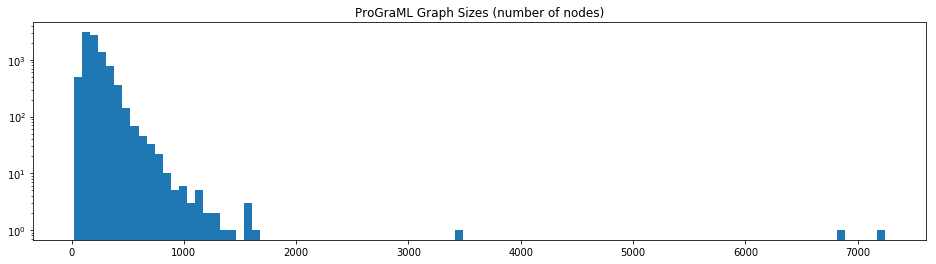

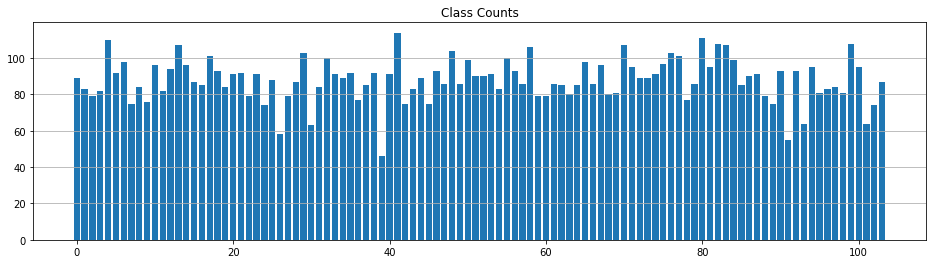

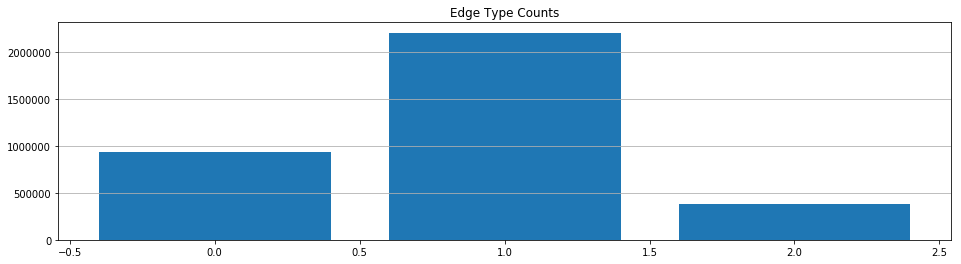

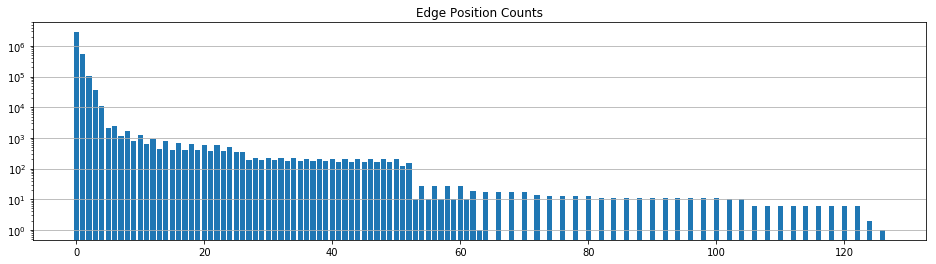

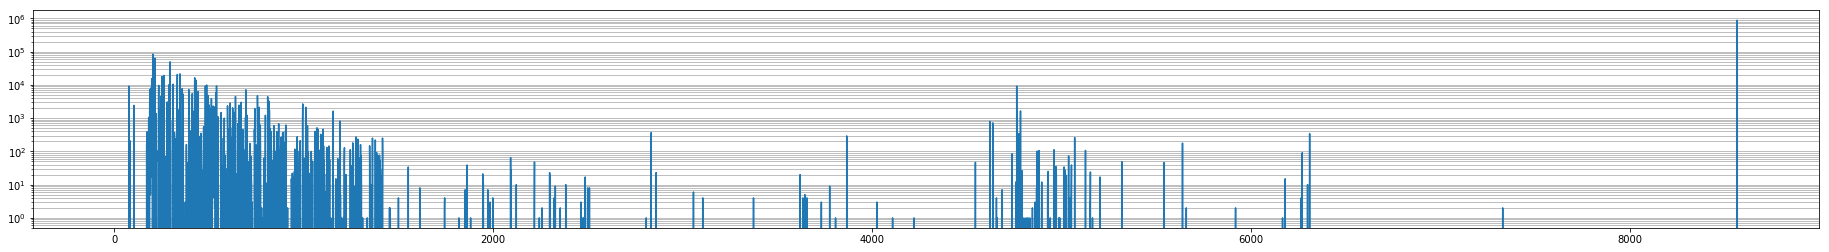

In [20]:
print_dataset_stats(valid_data)

### Test Set

In [21]:
test_data = POJ104Dataset(ds_dir, 'test')

  0%|          | 0/9227 [00:00<?, ?it/s]

Processing...
Creating test dataset at /home/zacharias/llvm_datasets/classifyapp_data
=== DATASET /home/zacharias/llvm_datasets/classifyapp_data/ir_test: Collecting .ll.p files into dataset


100%|██████████| 9227/9227 [00:20<00:00, 441.51it/s]


 * COMPLETED * === DATASET /home/zacharias/llvm_datasets/classifyapp_data/ir_test: now pre-filtering...
 * COMPLETED * === DATASET /home/zacharias/llvm_datasets/classifyapp_data/ir_test: Completed filtering, now pre_transforming...
Done!


In [22]:
test_data.data

Data(edge_attr=[3489088, 2], edge_index=[2, 3489088], x=[1958241, 2], y=[9227])

POJ104Dataset(9227)
No of unique tokens 645/8568.
No of tokens in ds: 1,958,241.
No of !UNK in data: 279,398 -- [14.27%].
No of !ID in data: 862,205 -- [44.03%].


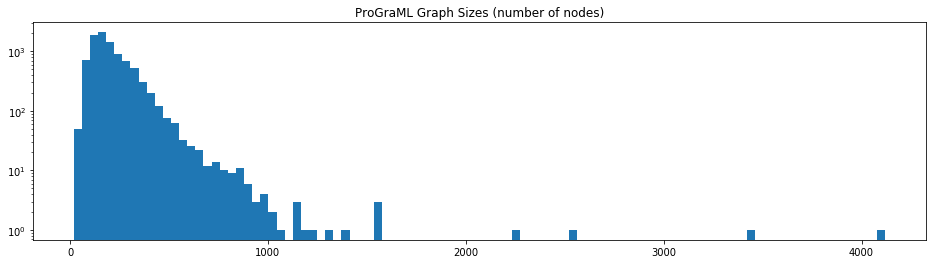

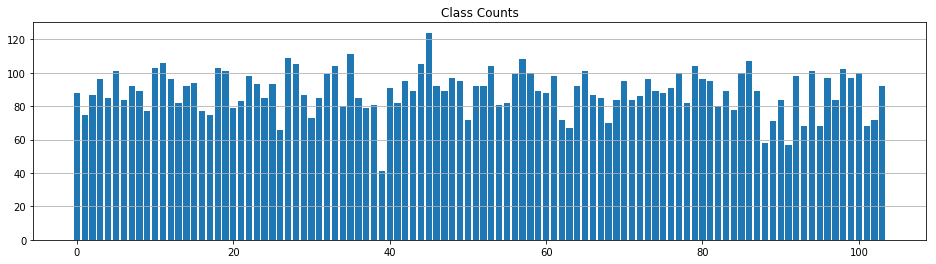

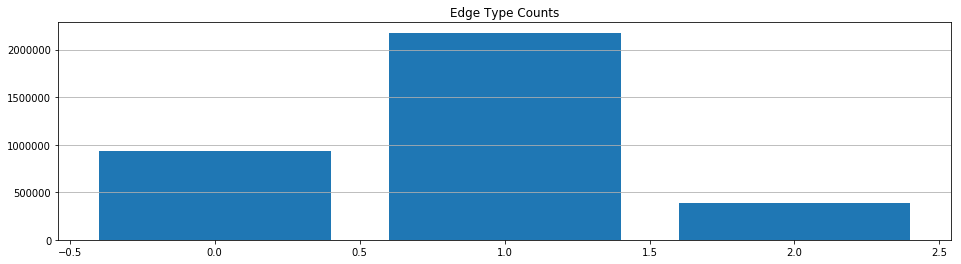

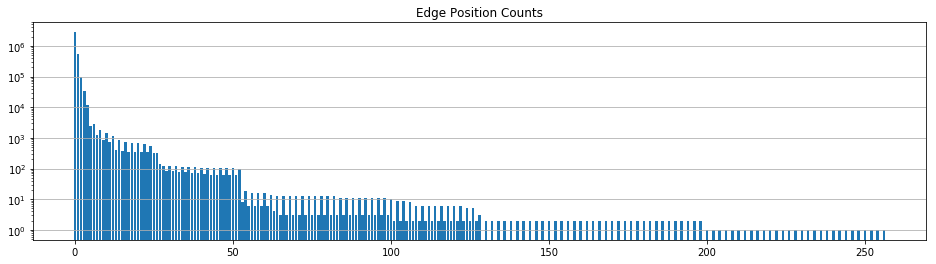

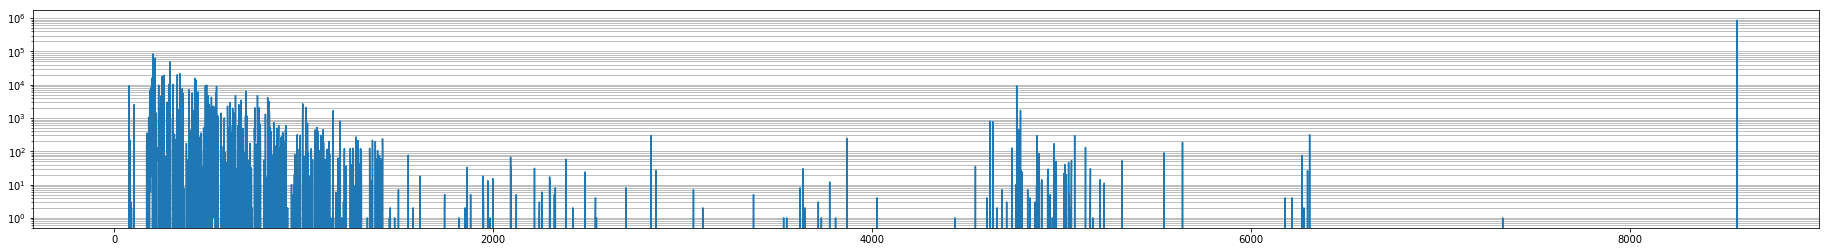

In [23]:
print_dataset_stats(test_data)

### Train Set

In [24]:
train_data = POJ104Dataset(ds_dir, 'train')
print(train_data.data)
print(train_data.data.num_nodes)
print("")

Processing...
Creating train dataset at /home/zacharias/llvm_datasets/classifyapp_data
=== DATASET /home/zacharias/llvm_datasets/classifyapp_data/ir_train: Collecting .ll.p files into dataset


100%|██████████| 221240/221240 [12:52<00:00, 286.21it/s]


 * COMPLETED * === DATASET /home/zacharias/llvm_datasets/classifyapp_data/ir_train: now pre-filtering...
 * COMPLETED * === DATASET /home/zacharias/llvm_datasets/classifyapp_data/ir_train: Completed filtering, now pre_transforming...
Done!
Data(edge_attr=[119995245, 2], edge_index=[2, 119995245], x=[66969996, 2], y=[221240])
66969996



POJ104Dataset(221240)
No of unique tokens 1220/8568.
No of tokens in ds: 66,969,996.
No of !UNK in data: 8,578,669 -- [12.81%].
No of !ID in data: 30,916,611 -- [46.16%].


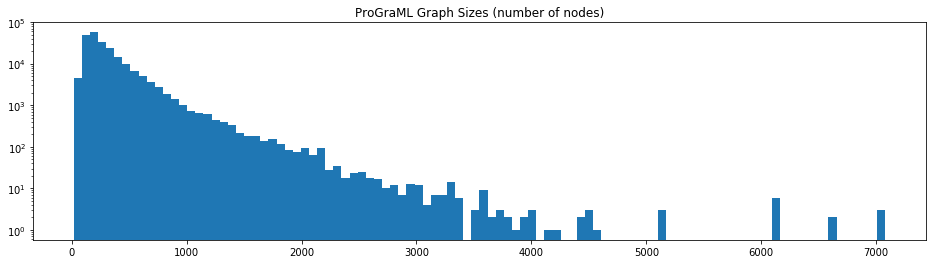

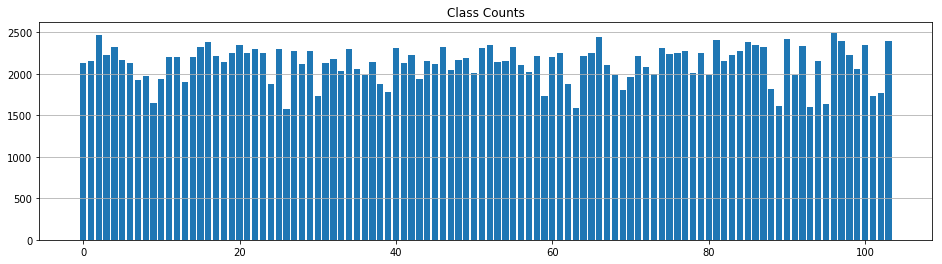

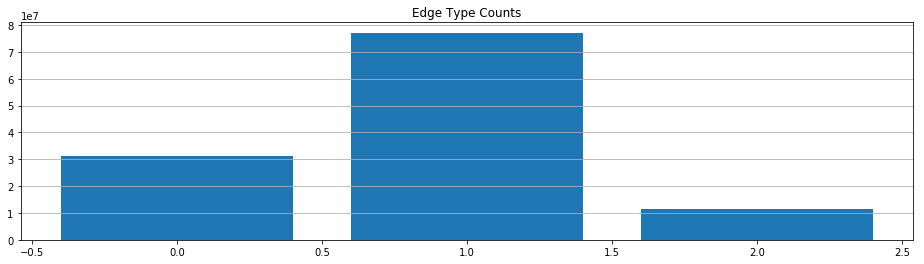

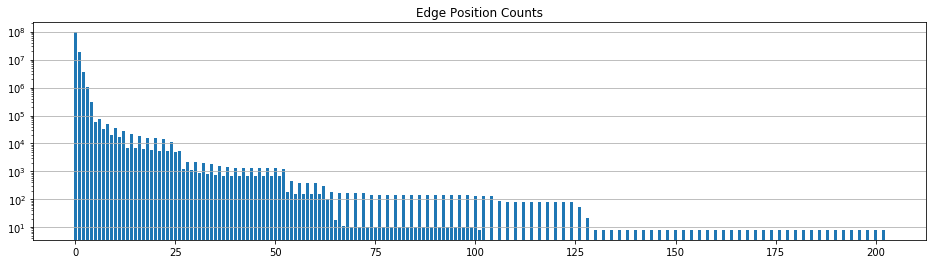

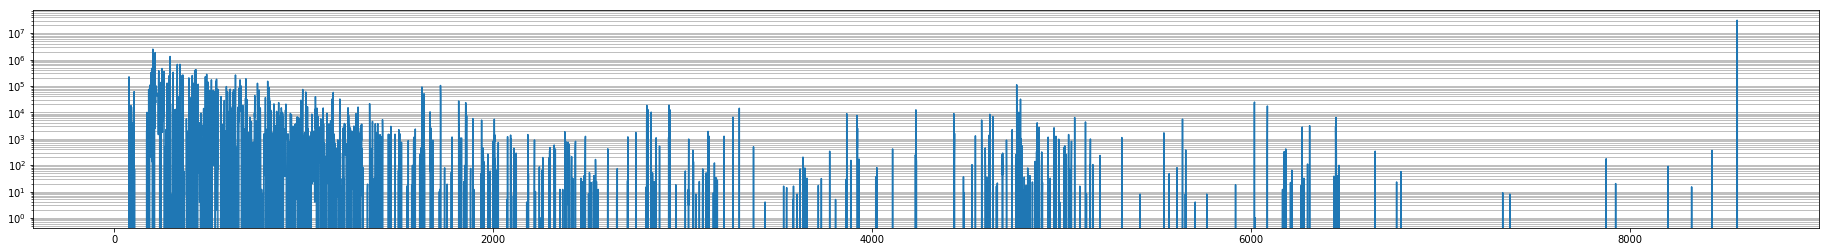

In [25]:
print_dataset_stats(train_data)

# Devmap

  5%|▍         | 32/680 [00:00<00:02, 280.63it/s]

Processing...

--- Read data from /home/zacharias/llvm_datasets/devmap_data/cgo17-amd.csv

--- Preparing to read 680 input files


100%|██████████| 680/680 [00:06<00:00, 104.91it/s]


 * COMPLETED * === DATASET Devmap-amd: now pre-filtering...
 * COMPLETED * === DATASET Devmap-amd: Completed filtering, now pre_transforming...
Done!
Data(aux_in=[680, 2], edge_attr=[807061, 2], edge_index=[2, 807061], runtimes=[680, 2], x=[429597, 2], y=[680])
429597

DevmapDataset(680)
No of unique tokens 384/8568.
No of tokens in ds: 429,597.
No of !UNK in data: 13,236 -- [3.08%].
No of !ID in data: 252,260 -- [58.72%].


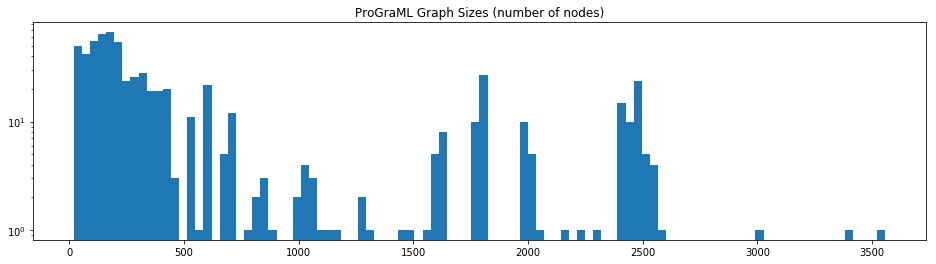

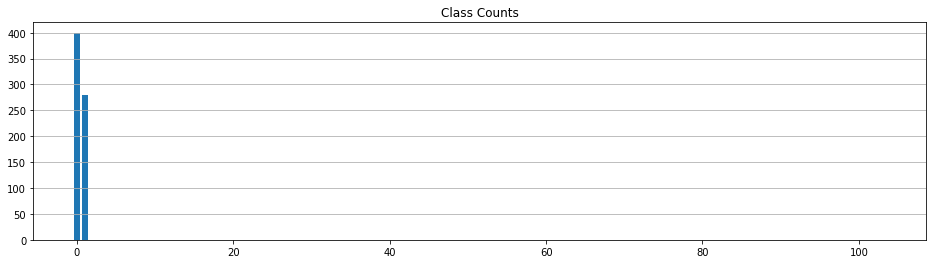

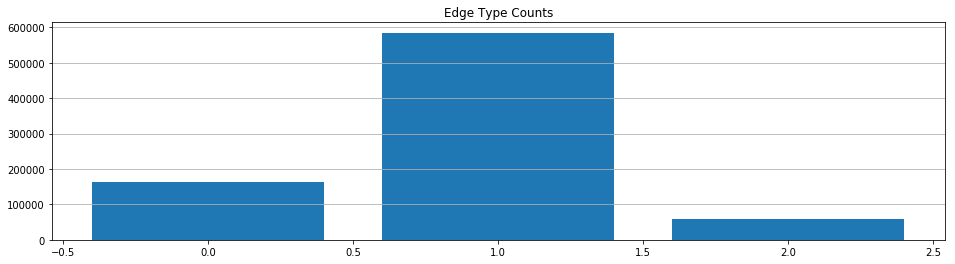

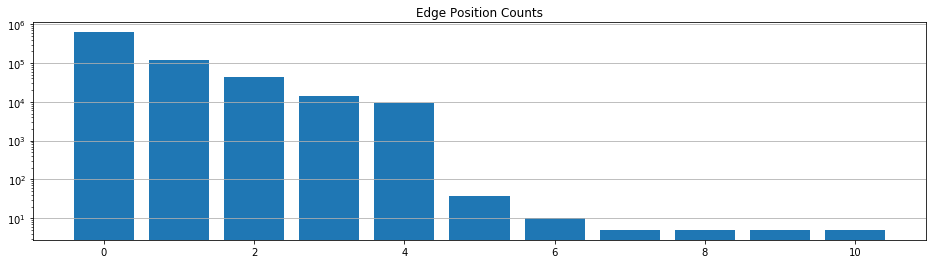

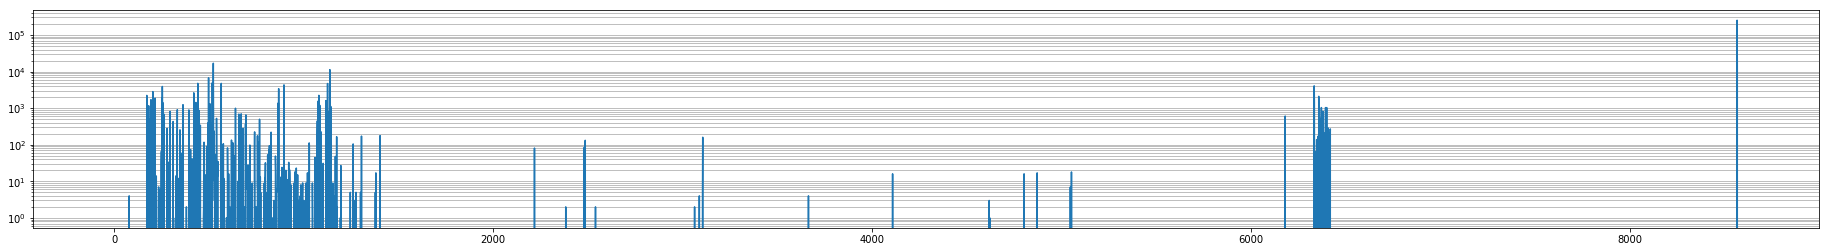

In [26]:
#root = '/mnt/data/llvm/master_thesis_datasets/devmap_data/'
root = '/home/zacharias/llvm_datasets/devmap_data/'
a = DevmapDataset(root, 'amd')
print(a.data)
print(a.data.num_nodes)
print("")
print_dataset_stats(a)

# Threadcoarsening

Data(edge_attr=[5730, 2], edge_index=[2, 5730], runtimes=[17, 6], x=[3312, 2], y=[17])
3312

ThreadcoarseningDataset(17)
No of unique tokens 110/8568.
No of tokens in ds: 3,312.
No of !UNK in data: 244 -- [7.37%].
No of !ID in data: 1,720 -- [51.93%].


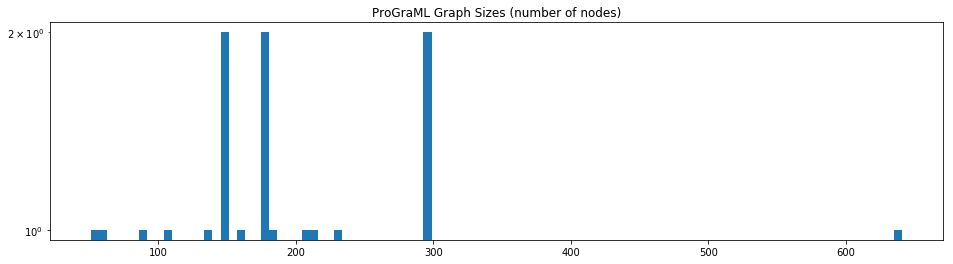

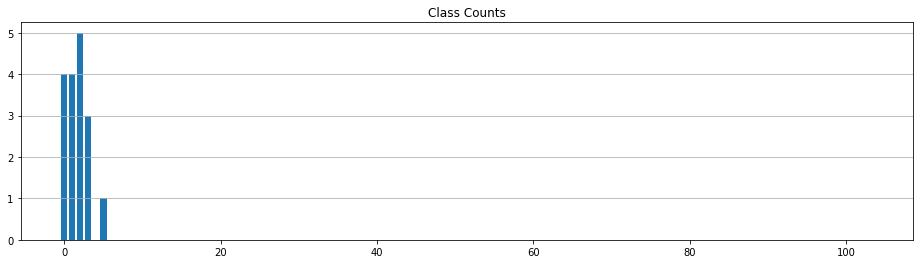

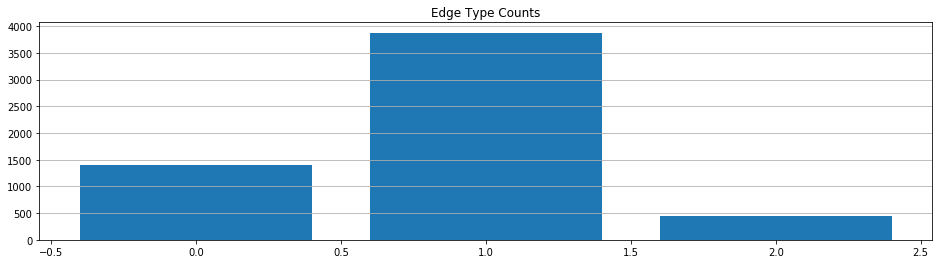

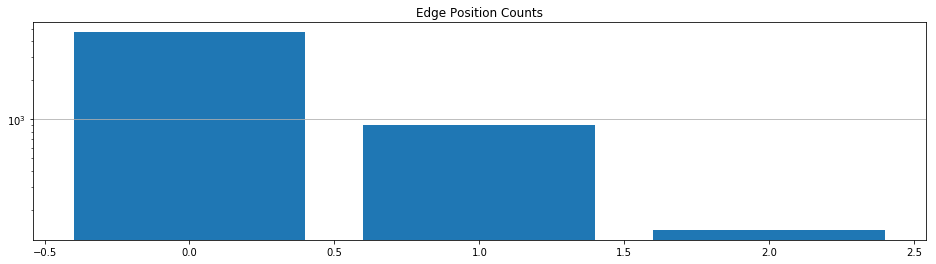

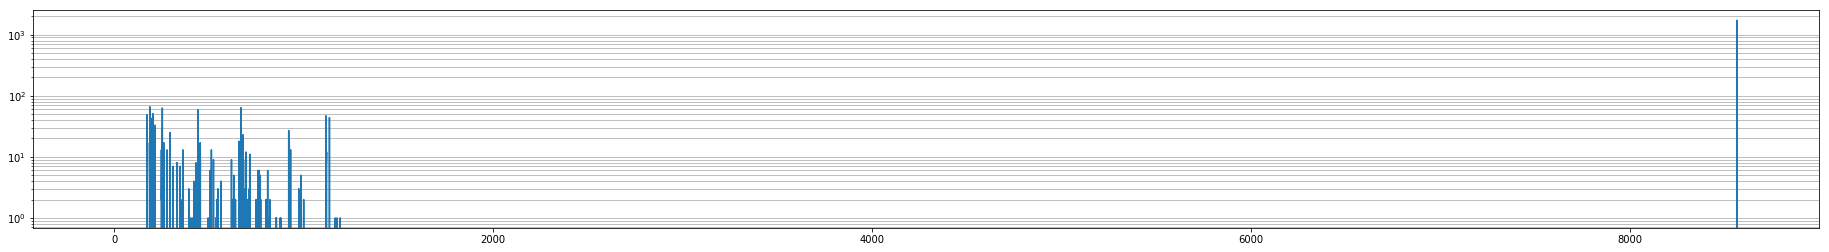

In [8]:
#root = '/mnt/data/llvm/master_thesis_datasets/threadcoarsening_data/'
root = '/home/zacharias/llvm_datasets/threadcoarsening_data/'
a = ThreadcoarseningDataset(root, 'Cypress')
print(a.data)
print(a.data.num_nodes)
print("")
print_dataset_stats(a)

In [13]:
baseline_runtimes = a.data.runtimes[:, 0]
print(baseline_runtimes)
base_avg = torch.mean(baseline_runtimes)
base_avg

tensor([4.7411e+05, 1.7839e+06, 5.3089e+05, 1.2000e+06, 1.5164e+06, 3.6100e+05,
        3.9103e+07, 3.5056e+05, 2.9333e+05, 2.0511e+06, 5.0180e+07, 1.1367e+08,
        3.8834e+06, 3.6923e+07, 4.1133e+05, 8.2000e+04, 1.0421e+07])


tensor(15484286.)

## _Tahiti, ...

In [21]:
#root = '/mnt/data/llvm/master_thesis_datasets/threadcoarsening_data/'
root = '/home/zacharias/llvm_datasets/threadcoarsening_data/'
a = ThreadcoarseningDataset(root, 'Fermi')
print(a.data)
print(a.data.num_nodes)
print("")
print_dataset_stats(a)

Processing...
	Reading data from /home/zacharias/llvm_datasets/threadcoarsening_data/pact-2014-oracles.csv 
	and /home/zacharias/llvm_datasets/threadcoarsening_data/pact-2014-runtimes.csv
 kernel=        binarySearch is missing cf=32. Ad-hoc inserting result from last existing coarsening factor.
 kernel=        blackscholes is missing cf=16. Ad-hoc inserting result from last existing coarsening factor.
 kernel=        blackscholes is missing cf=32. Ad-hoc inserting result from last existing coarsening factor.
 kernel=         convolution is missing cf=32. Ad-hoc inserting result from last existing coarsening factor.
 kernel=           dwtHaar1D is missing cf=32. Ad-hoc inserting result from last existing coarsening factor.
 kernel=           fastWalsh is missing cf=32. Ad-hoc inserting result from last existing coarsening factor.
 kernel=                mriQ is missing cf=32. Ad-hoc inserting result from last existing coarsening factor.
 kernel=              mvCoal is missing cf=32. Ad

AssertionError: 

In [ ]:
baseline_runtimes = a.data.runtimes[:, 0]
print(baseline_runtimes)
base_avg = torch.mean(baseline_runtimes)
base_avg

# NCC 

In [8]:
#root = '/mnt/data/llvm/master_thesis_datasets/old_unsupervised_ncc_data/'
root = '/home/zacharias/llvm_datasets/ncc_data/'
a = NCCDataset(root, 'train')

Data(edge_attr=[188493379, 2], edge_index=[2, 188493379], x=[98956919, 2])
98956919

NCCDataset(27428)
No of unique tokens 7276/8568.
No of tokens in ds: 98,956,919.
No of !UNK in data: 5,182,256 -- [5.24%].
No of !ID in data: 51,794,982 -- [52.34%].


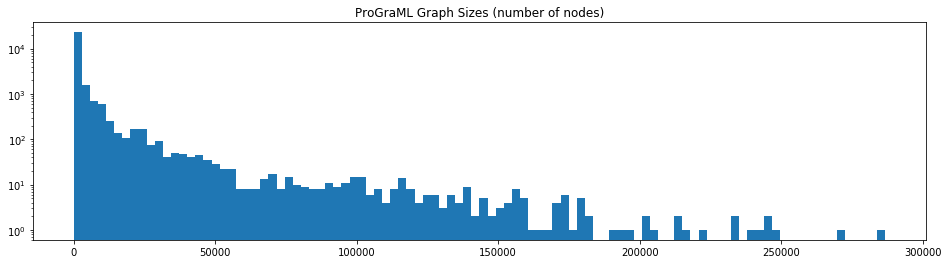

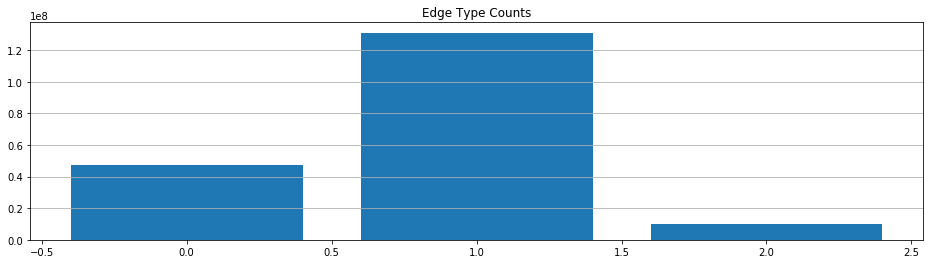

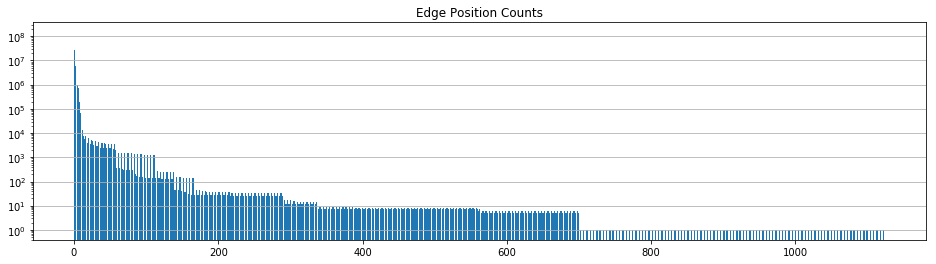

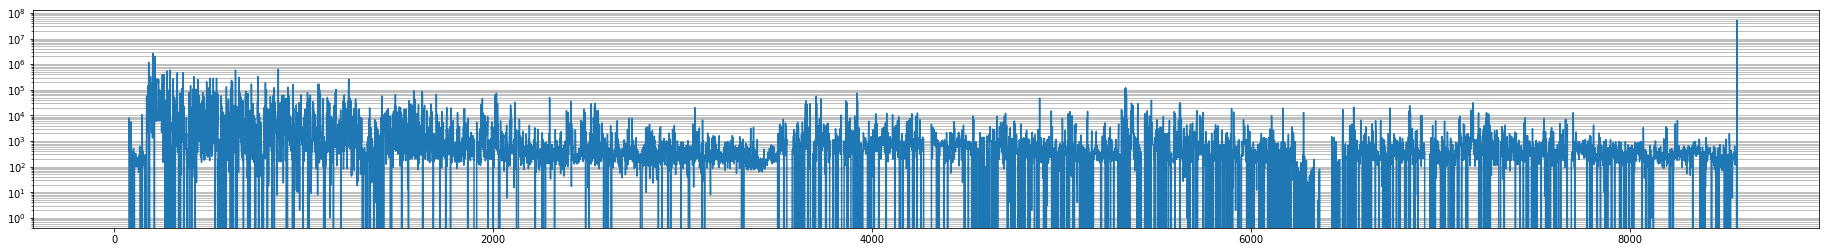

In [9]:
print(a.data)
print(a.data.num_nodes)
print("")
print_dataset_stats(a)

In [10]:
del a

## (final) reprocessing on hdd

In [6]:
root = '/mnt/data/llvm/master_thesis_datasets/ncc_data/'
#root = '/home/zacharias/llvm_datasets/ncc_data/'
a = NCCDataset(root, 'train')

Processing...
Creating train dataset at /mnt/data/llvm/master_thesis_datasets/ncc_data
=== DATASET /mnt/data/llvm/master_thesis_datasets/ncc_data: Collecting .data.p files into dataset


  0%|          | 37/27580 [00:00<07:19, 62.69it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/linux-4.15/ir_1/drivers_acpi_acpica_utg.llbal.ll.p! Skipping ...


  1%|          | 331/27580 [00:05<07:48, 58.20it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/linux-4.15/ir_1/drivers_acpi_acpica_rsin.ll.ll.p! Skipping ...


  3%|▎         | 960/27580 [00:22<06:58, 63.57it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/linux-4.15/ir_0/arch_x86_kernel_cpu_capflags.ll.p! Skipping ...


  6%|▌         | 1618/27580 [00:50<18:14, 23.72it/s]  

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/linux-4.15/ir_6/mm_init-mm.ll.p! Skipping ...


  7%|▋         | 1983/27580 [01:17<3:39:00,  1.95it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/amd_app_sdk/amd/SobolPrimitives.ll.p! Skipping ...


  8%|▊         | 2072/27580 [01:29<1:03:05,  6.74it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ratt_cl.ll.p! Skipping ...


  8%|▊         | 2083/27580 [01:30<57:08,  7.44it/s]  

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/rdsmh_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/rdwdot7_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/qssab_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ratt4_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/rdwdot_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/gr_base_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/rdwdot6_cl.ll.p! Skipping ...


  8%|▊         | 2097/27580 [01:33<1:24:53,  5.00it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/qssa2_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ratt7_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ratt2_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/reduction_cl.ll.p! Skipping ...


  8%|▊         | 2101/27580 [01:34<1:17:15,  5.50it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ratt6_cl.ll.p! Skipping ...


  8%|▊         | 2104/27580 [01:35<1:19:22,  5.35it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/bfs_uiuc_spill_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ratt5_cl.ll.p! Skipping ...


  8%|▊         | 2109/27580 [01:35<1:04:59,  6.53it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/stencil2d_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ratx_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ratt8_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/qssa_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ProgressBar.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ratt9_cl.ll.p! Skipping ...


  8%|▊         | 2117/27580 [01:35<50:00,  8.49it/s]  

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/scan_cl.ll.p! Skipping ...


  8%|▊         | 2122/27580 [01:36<47:27,  8.94it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ratx4_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/spmv_cl.ll.p! Skipping ...


  8%|▊         | 2129/27580 [01:36<36:07, 11.74it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/rdwdot2_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/bfs_iiit_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/fft_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/md5_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ratt10_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ratx2_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/sort_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. emp

  8%|▊         | 2146/27580 [01:36<26:32, 15.97it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/rdwdot8_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/rdwdot9_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/rdwdot3_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/md_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/ratxb_cl.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/shoc/sho/gemmN_cl.ll.p! Skipping ...


 69%|██████▉   | 19090/27580 [06:06<12:46, 11.08it/s]  

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/opencv/ir_3/llpencv_.llre.dir.llpencl_kernels_.llre.cpp.ll.p! Skipping ...


 92%|█████████▏| 25294/27580 [20:24<01:51, 20.41it/s]  

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tensorflow/ir_0/darwin-opt_bin_external_com_googlesource_code_re2__objs_re2_external_com_googlesource_code_re2_re2_unicode_casefold.ll.p! Skipping ...


 92%|█████████▏| 25484/27580 [20:38<01:18, 26.86it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tensorflow/ir_0/darwin-opt_bin_external_com_googlesource_code_re2__objs_re2_external_com_googlesource_code_re2_re2_unicode_groups.ll.p! Skipping ...


 93%|█████████▎| 25653/27580 [21:03<03:09, 10.16it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tensorflow/ir_5/host_bin_external_com_googlesource_code_re2__objs_re2_external_com_googlesource_code_re2_re2_unicode_casefold.ll.p! Skipping ...


 93%|█████████▎| 25720/27580 [21:12<04:14,  7.30it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tensorflow/ir_5/host_bin_external_com_googlesource_code_re2__objs_re2_external_com_googlesource_code_re2_re2_unicode_groups.ll.p! Skipping ...


 93%|█████████▎| 25727/27580 [21:12<02:54, 10.65it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tensorflow/ir_5/host_bin_external_protobuf_archive__objs_protoc_lib_external_protobuf_archive_src_google_protobuf_compiler_js_well_known_types_embed.ll.p! Skipping ...


 94%|█████████▎| 25810/27580 [21:24<04:16,  6.91it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tensorflow/ir_5/host_bin_external_pcre__objs_pcre_external_pcre_pcre_tables.ll.p! Skipping ...


 94%|█████████▍| 25879/27580 [21:35<05:31,  5.13it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tensorflow/ir_5/host_bin_external_com_googlesource_code_re2__objs_re2_external_com_googlesource_code_re2_re2_perl_groups.ll.p! Skipping ...


 98%|█████████▊| 26922/27580 [26:26<00:25, 25.80it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tal_ncc_inst2vec/cudasamples-bytecode/sobol_primitives.ll.p! Skipping ...


 98%|█████████▊| 26953/27580 [26:29<00:48, 12.81it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tal_ncc_inst2vec/cudasamples-bytecode/matrixMul_kernel_32_ptxdump.ll.p! Skipping ...


 98%|█████████▊| 26974/27580 [26:31<01:05,  9.30it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tal_ncc_inst2vec/cudasamples-bytecode/SmokeShaders.ll.p! Skipping ...


 98%|█████████▊| 26985/27580 [26:32<00:50, 11.85it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tal_ncc_inst2vec/cudasamples-bytecode/matrixMul_kernel_64_ptxdump.ll.p! Skipping ...


 98%|█████████▊| 27062/27580 [26:39<00:33, 15.45it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tal_ncc_inst2vec/cudasamples-bytecode/shaders.ll.p! Skipping ...


 98%|█████████▊| 27114/27580 [26:43<00:51,  9.01it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tal_ncc_inst2vec/cudasamples-bytecode/bisect_util.ll.p! Skipping ...
Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tal_ncc_inst2vec/cudasamples-bytecode/simpleDeviceLibrary.ll.p! Skipping ...


 98%|█████████▊| 27151/27580 [26:45<00:22, 18.95it/s]

Failing nx2data bc IndexError (prob. empty graph) on /mnt/data/llvm/master_thesis_datasets/ncc_data/tal_ncc_inst2vec/cudasamples-bytecode/dgetf2.ll.p! Skipping ...


100%|██████████| 27580/27580 [27:09<00:00, 16.93it/s]


 * COMPLETED * === DATASET /mnt/data/llvm/master_thesis_datasets/ncc_data: now pre-filtering...
 * COMPLETED * === DATASET /mnt/data/llvm/master_thesis_datasets/ncc_data: Completed filtering, now pre_transforming...
 * COMPLETED * === DATASET /mnt/data/llvm/master_thesis_datasets/ncc_data: saving to disk...
Done!


Data(edge_attr=[190242787, 2], edge_index=[2, 190242787], x=[99771045, 2])
99771045

NCCDataset(27520)
No of unique tokens 7293/8568.
No of tokens in ds: 99,771,045.
No of !UNK in data: 5,248,724 -- [5.26%].
No of !ID in data: 52,133,631 -- [52.25%].


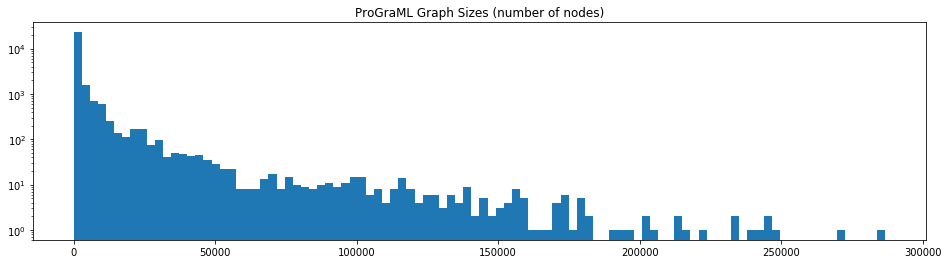

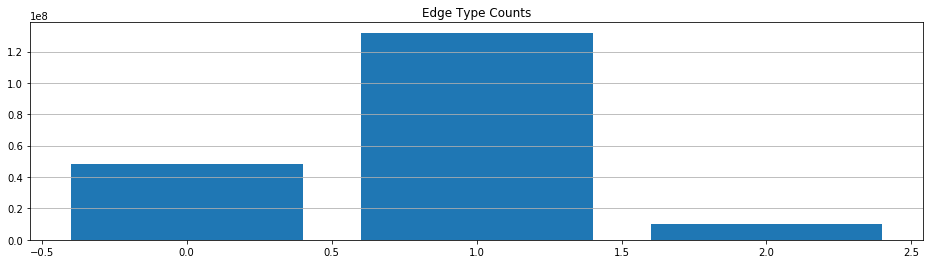

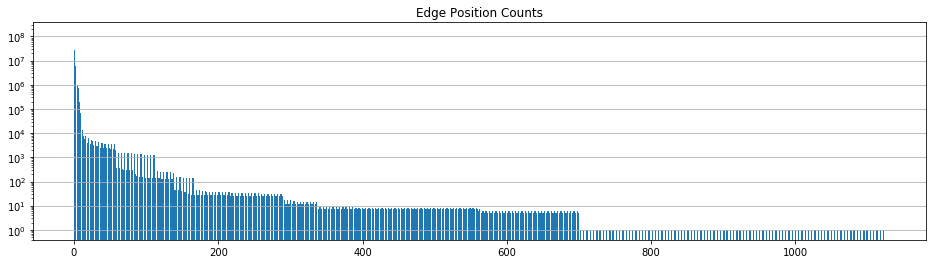

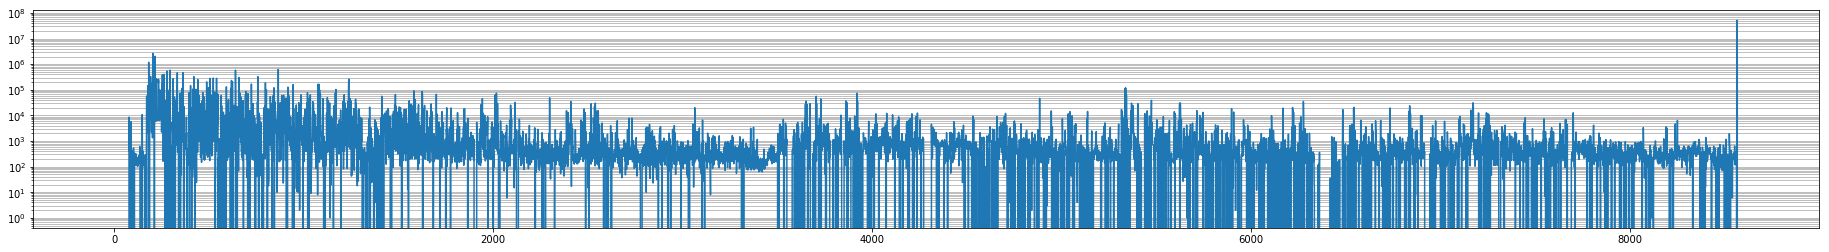

In [7]:
print(a.data)
print(a.data.num_nodes)
print("")
print_dataset_stats(a)

In [ ]:
del a

# Branch Prediction

Data(edge_attr=[8066693, 2], edge_index=[2, 8066693], profile_info=[4204153, 4], x=[4204153, 2])
4204153

BranchPredictionDataset(84)
No of unique tokens 1306/8568.
No of tokens in ds: 4,204,153.
No of !UNK in data: 436,988 -- [10.39%].
No of !ID in data: 2,204,244 -- [52.43%].


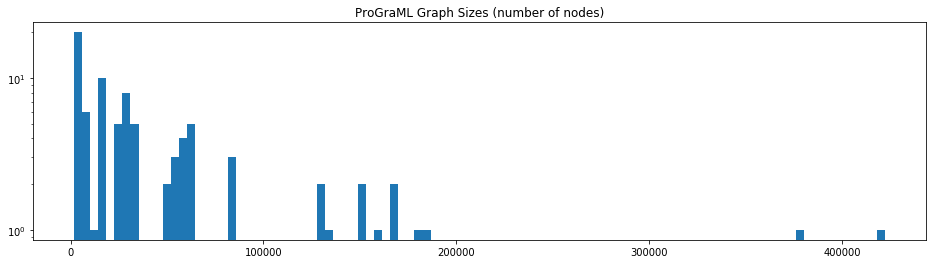

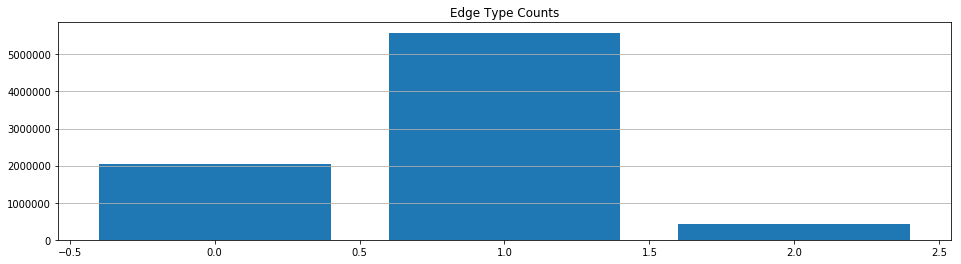

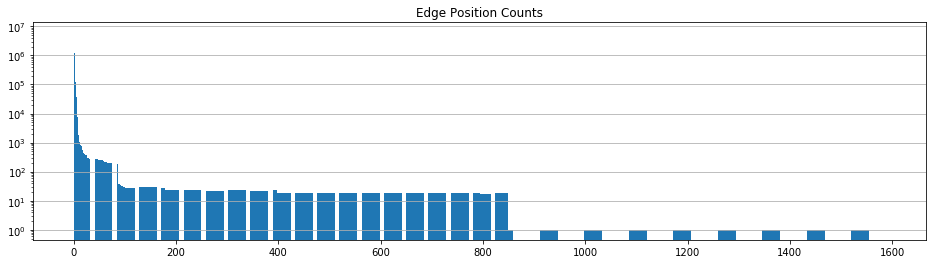

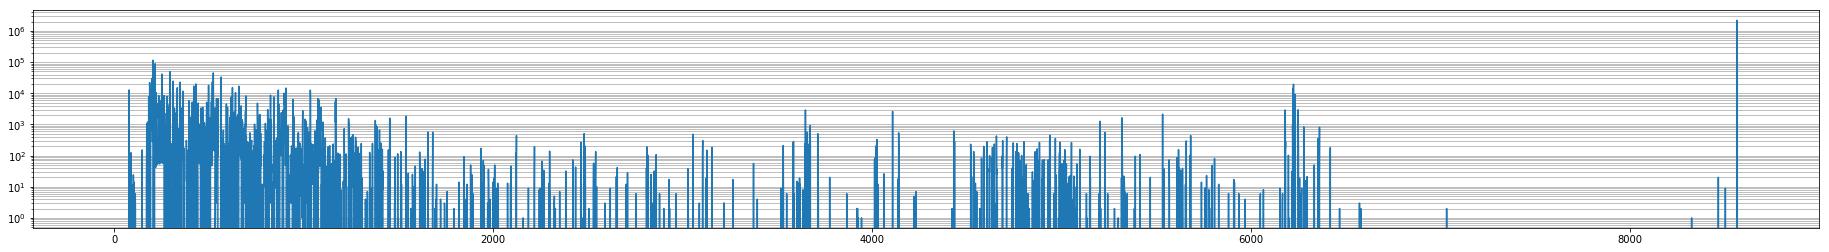

In [22]:
#root = '/mnt/data/llvm/master_thesis_datasets/old_unsupervised_ncc_data/'
root = '/home/zacharias/llvm_datasets/branch_prediction_data/'
a = BranchPredictionDataset(root, 'train')
print(a.data)
print(a.data.num_nodes)
print("")
print_dataset_stats(a)

In [23]:
# number of targets to train on!
torch.sum(a.data.profile_info[:,0])

tensor(51407)

In [24]:
a.data.profile_info[:,0]

tensor([0, 0, 0,  ..., 0, 0, 0])

## without spec

/home/zacharias/ProGraML/deeplearning/ml4pl/models/ggnn/run.py
/home/zacharias/ProGraML
Data(edge_attr=[1871058, 2], edge_index=[2, 1871058], profile_info=[932405, 4], x=[932405, 2])
932405

BranchPredictionDataset(47)
No of unique tokens 507/8568.
No of tokens in ds: 932,405.
No of !UNK in data: 76,429 -- [8.20%].
No of !ID in data: 477,414 -- [51.20%].


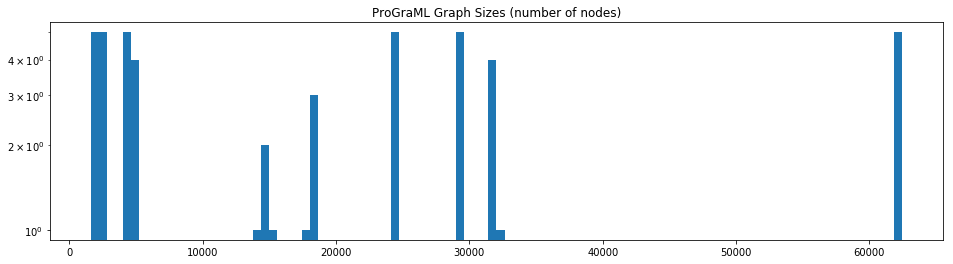

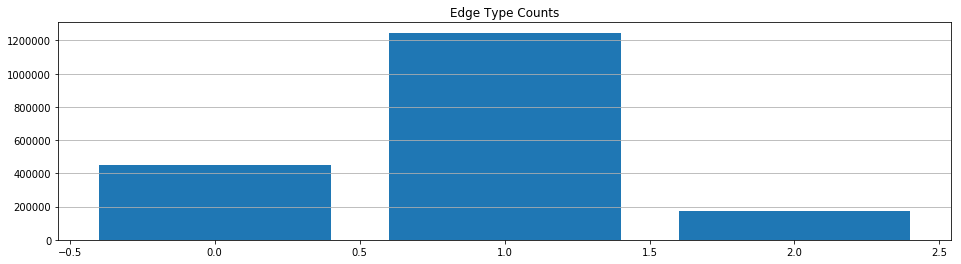

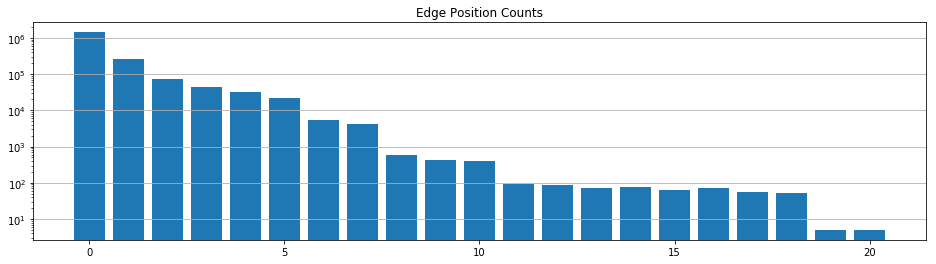

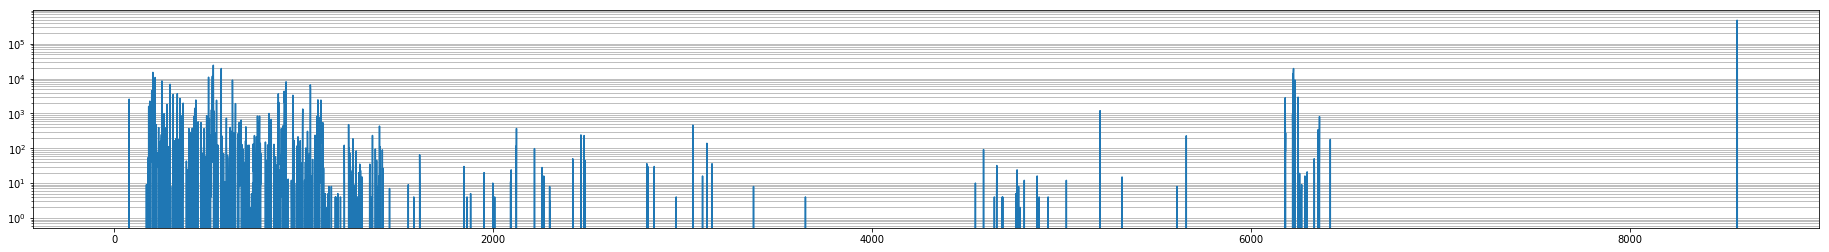

In [15]:
#root = '/mnt/data/llvm/master_thesis_datasets/old_unsupervised_ncc_data/'
root = '/home/zacharias/llvm_datasets/branch_prediction_data/'
a = BranchPredictionDataset(root, 'train')
print(a.data)
print(a.data.num_nodes)
print("")
print_dataset_stats(a)

In [16]:
# number of targets to train on!
torch.sum(a.data.profile_info[:,0])

tensor(10997)

In [18]:
a.data.profile_info[:,0]

tensor([0, 0, 0,  ..., 0, 0, 0])

# Where did all the inst2vec tokens go?

In [1]:
import pickle

In [13]:
text_dic = {}

ds_base = Path('/mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data')

#files = list(ds_base.rglob('*.data.p'))
files = list(ds_base.rglob('*.ll.pickle'))

for j, file in enumerate(tqdm.tqdm(files)):
    if j > 1000: break[]
    if not file.is_file():
        continue
    try:
        with open(file, 'rb') as f:
            g = pickle.load(f)
        #nx_graph = load(file)
    except EOFError:
        print(f"Failing to unpickle bc. EOFError on {file}! Skipping ...")
        continue
    try:
        for i, node in g.nodes(data=True):
            text = node['preprocessed_text']
            if text in text_dic:
                text_dic[text] = text_dic[text] + 1
            else:
                text_dic[text] = 1
    except IndexError:
        print(f"Failing nx2data bc IndexError (prob. empty graph) on {file}! Skipping ...")
        continue


  2%|▏         | 461/27610 [00:09<18:53, 23.94it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_2/drivers_gpu_drm_i915_intel_hangcheck.ll.pickle! Skipping ...


  3%|▎         | 732/27610 [00:16<12:55, 34.67it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_printf.ll.pickle! Skipping ...


  3%|▎         | 750/27610 [00:16<10:42, 41.80it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_me.llry.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_pm.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_vid.ll-vga.ll.pickle! Skipping ...


  3%|▎         | 764/27610 [00:16<09:05, 49.23it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_cpuflags.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_regs.ll.pickle! Skipping ...


  3%|▎         | 778/27610 [00:17<08:46, 50.95it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_real.llde_rm_vid.ll-vga.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_cpucheck.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_real.llde_rm_vid.ll-vesa.ll.pickle! Skipping ...


  3%|▎         | 798/27610 [00:17<07:13, 61.81it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_a20.ll.pickle! Skipping ...


  3%|▎         | 853/27610 [00:18<06:07, 72.73it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_early_serial_.lln.llle.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_vid.ll-.llde.ll.pickle! Skipping ...


  3%|▎         | 898/27610 [00:19<10:11, 43.65it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_cpu.ll.pickle! Skipping ...


  3%|▎         | 932/27610 [00:19<08:05, 54.90it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_vid.ll.ll.pickle! Skipping ...


  3%|▎         | 952/27610 [00:19<07:09, 62.07it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_vid.ll-vesa.ll.pickle! Skipping ...


  4%|▎         | 976/27610 [00:20<06:09, 72.14it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_real.llde_rm_vid.ll-.llde.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_cmdline.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_real.llde_rm_vid.ll-b.lls.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_tty.ll.pickle! Skipping ...


  4%|▎         | 1019/27610 [00:20<05:41, 77.89it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_main.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_real.llde_rm_regs.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_vid.ll-b.lls.ll.pickle! Skipping ...


  4%|▍         | 1042/27610 [00:20<05:48, 76.21it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_.llot_string.ll.pickle! Skipping ...


  4%|▍         | 1050/27610 [00:21<06:20, 69.75it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/linux-4.15/ir_0/arch_x86_real.llde_rm_wakemain.ll.pickle! Skipping ...


  8%|▊         | 2105/27610 [01:15<24:40, 17.23it/s]  

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/shoc/sho/QueueDelay.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/shoc/sho/FFT.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/shoc/sho/MD.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/shoc/sho/Spmv.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/shoc/sho/Timer.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/shoc/sho/S3D.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/shoc/sho/Sort.ll.pickle! Sk

  8%|▊         | 2170/27610 [01:15<17:26, 24.31it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/shoc/sho/ResultDatabase.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/shoc/sho/OpenCLPlatform.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/shoc/sho/Triad.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/shoc/sho/Stencil2Dmain.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/shoc/sho/BusSpeedReadback.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/shoc/sho/Scan.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervis

 88%|████████▊ | 24224/27610 [13:48<01:19, 42.73it/s]  

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/clutils.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/nn_clutils.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/leukocyte_avilib.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/read_input.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/hotspot.ll.pickle! Skipping ...


 88%|████████▊ | 24247/27610 [13:48<01:24, 39.65it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/kmeans.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/gaussianElim.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/bfs_timer.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/nearestNeighbor.ll.pickle! Skipping ...


 88%|████████▊ | 24263/27610 [13:49<01:29, 37.45it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/find_ellipse_opencl.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/nw.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/backprop.ll.pickle! Skipping ...


 88%|████████▊ | 24280/27610 [13:49<01:13, 45.59it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/pythfinder_OpenCL.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/find_ellipse.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/common.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/pathfinder_main.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/lud.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/rodinia_3.1/ro/dwt2d.ll.pickle! Skipping ...


 92%|█████████▏| 25280/27610 [15:36<01:29, 26.10it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tensorflow/ir_0/darwin-opt_bin_external_org_sqlite__objs_org_sqlite_external_org_sqlite_sqlite3.ll.pickle! Skipping ...


 92%|█████████▏| 25409/27610 [15:41<01:23, 26.48it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tensorflow/ir_0/darwin-opt_bin_external_nsync__objs_nsync_cpp_external_nsync_platform_c++11_src_time_rep_timespec.ll.pickle! Skipping ...


 94%|█████████▍| 25921/27610 [16:29<01:39, 16.93it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tensorflow/ir_5/host_bin_external_nsync__objs_nsync_cpp_external_nsync_platform_c++11_src_time_rep_timespec.ll.pickle! Skipping ...


 98%|█████████▊| 27069/27610 [19:49<00:18, 28.53it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/cudasamples-bytecode/randomFog.ll.pickle! Skipping ...


 99%|█████████▊| 27199/27610 [19:53<00:13, 30.67it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/jobcntl.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/erhs.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/cg.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/pintgr.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/ft.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/print_results.

 99%|█████████▊| 27226/27610 [19:53<00:08, 46.02it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/exact_rhs.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/initialize.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/error.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/adc.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/bt.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/convec

 99%|█████████▊| 27240/27610 [19:53<00:07, 47.43it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/lu.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/mg.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/verify.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/setbv.ll.pickle! Skipping ...


 99%|█████████▊| 27252/27610 [19:54<00:07, 50.35it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/extbuild.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/omp/precond.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/jobcntl.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/cg.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/pintgr.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/print

 99%|█████████▉| 27292/27610 [19:54<00:04, 67.86it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/convect.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/auxfnct.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/transfer.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/ep.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/lu.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/mg.ll.pic

 99%|█████████▉| 27312/27610 [19:54<00:04, 59.71it/s]

Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/setbv.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/appft.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/extbuild.ll.pickle! Skipping ...
Failing to unpickle bc. EOFError on /mnt/data/llvm/master_thesis_datasets/fresh_new_unsupervised_ncc_data/tal_ncc_inst2vec/nas/bytecode/ser/precond.ll.pickle! Skipping ...


100%|██████████| 27610/27610 [20:02<00:00, 36.37it/s]


In [16]:
with open('/mnt/data/llvm/master_thesis_datasets/token_analysis.pickle', 'wb') as f:
    pickle.dump(text_dic, f)

In [18]:
text_list = [(v, k) for k,v in text_dic.items()]

In [22]:
text_list = sorted(text_list, reverse=True)

In [23]:
with open('/home/zacharias/ProGraML/deeplearning/ml4pl/poj104/vocabulary/dic_pickle', 'rb') as f:
    golden_dic = pickle.load(f)

In [24]:
golden_dic

{'<@ID> = internal global { i8 } zeroinitializer, align 1': 0,
 '<@ID> = global i32 <INT>, align 4': 1,
 '<@ID> = private unnamed_addr constant [42 x i8]  <STRING>, align 1': 2,
 '<@ID> = private unnamed_addr constant [12 x i8]  <STRING>, align 1': 3,
 '<@ID> = private unnamed_addr constant [68 x i8]  <STRING>, align 1': 4,
 '<@ID> = private unnamed_addr constant [2 x i8]  <STRING>, align 1': 5,
 '<@ID> = private unnamed_addr constant [17 x i8]  <STRING>, align 1': 6,
 '<@ID> = private unnamed_addr constant [1 x i8] zeroinitializer, align 1': 7,
 '<@ID> = private unnamed_addr constant [4 x i8]  <STRING>, align 1': 8,
 '<@ID> = private unnamed_addr constant [21 x i8]  <STRING>, align 1': 9,
 '<@ID> = private unnamed_addr constant [24 x i8]  <STRING>, align 1': 10,
 '<@ID> = private unnamed_addr constant [32 x i8]  <STRING>, align 1': 11,
 '<@ID> = private unnamed_addr constant [20 x i8]  <STRING>, align 1': 12,
 '<@ID> = private unnamed_addr constant [29 x i8]  <STRING>, align 1': 13,
 

In [25]:
golden_set = set([k for k,v in golden_dic.items()])

In [27]:
text_set = set([t for _, t in text_list])

In [29]:
len(text_set)

102282

In [30]:
golden_remaining = golden_set - text_set

In [31]:
len(golden_remaining)

6281

In [35]:
text_remaining = []
for s, t in text_list:
    if t in golden_dic:
        text_remaining.append((True, s, t))
    else:
        text_remaining.append((False, s, t))

In [38]:
minor_test = [e for e in text_remaining if '<{' in e[2]]

In [40]:
len(minor_test)

84

In [41]:
minor_test

[(True,
  3845,
  '<%ID> = getelementptr inbounds <{ double, double }>, <{ double, double }>* <%ID>, i64 <%ID>, i32 <INT>'),
 (True,
  2262,
  '<%ID> = getelementptr inbounds <{ float, float }>, <{ float, float }>* <%ID>, i64 <INT>, i32 <INT>'),
 (True, 2163, '<%ID> = bitcast i64* <%ID> to <{ float, float }>*'),
 (True, 776, '<%ID> = bitcast i64* <%ID> to <{ double, double }>*'),
 (False,
  51,
  '<%ID> = getelementptr inbounds <{ double, double }>, <{ double, double }>* <%ID>, i64 <INT>, i32 <INT>'),
 (False,
  40,
  '<%ID> = getelementptr <{ double, double }>, <{ double, double }>* <%ID>, i64 <%ID>'),
 (False, 26, '<%ID> = bitcast <{ double, double }>* <%ID> to <2 x i64>*'),
 (False, 14, '<%ID> = bitcast <{ double, double }>* <%ID> to i64*'),
 (False, 12, '<%ID> = bitcast <{ float, float }>* <%ID> to i8*'),
 (False,
  10,
  '<%ID> = load i8, i8* getelementptr inbounds (<{ { i8*, i8*, i8, { <%ID> }, <%ID> }, { i8*, i8*, i8, { <%ID> }, <%ID> }, { i8*, i8*, i8, { <%ID> }, <%ID> }, { i8*

In [36]:
text_remaining

[(False, 51794903, '!IDENTIFIER'),
 (True, 2649881, 'br i1 <%ID>, label <%ID>, label <%ID>'),
 (True, 2025947, 'br label <%ID>'),
 (False, 1428779, '!IMMEDIATE'),
 (True, 1185524, '<%ID> = load i64, i64* <%ID>, align 8'),
 (False,
  1126393,
  '<%ID> = getelementptr inbounds <%ID>, <%ID>* <%ID>, i64 <INT>, i32 <INT>'),
 (True, 986102, 'call void <@ID>(i64 <INT>, i8* nonnull <%ID>)'),
 (False, 935089, '<%ID> = load <%ID>*, <%ID>** <%ID>, align 8'),
 (False, 718087, ''),
 (True, 701956, 'store i64 <%ID>, i64* <%ID>, align 8'),
 (True,
  634407,
  '<%ID> = getelementptr inbounds double, double* <%ID>, i64 <%ID>'),
 (False, 597780, '<%ID> = bitcast <%ID>* <%ID> to i8*'),
 (True, 584467, '<%ID> = load i32, i32* <%ID>, align 4'),
 (True, 583792, '<%ID> = add nsw i64 <%ID>, <INT>'),
 (True, 544773, '<%ID> = icmp eq i64 <%ID>, <INT>'),
 (False,
  528458,
  '<%ID> = getelementptr inbounds <%ID>, <%ID>* <%ID>, i64 <INT>, i32 <INT>, i32 <INT>'),
 (False, 476275, 'store <%ID>* <%ID>, <%ID>** <%ID>

In [44]:
alloca_test = [e for e in text_remaining if 'alloca' in e[2]]
len(alloca_test)

1237

In [45]:
alloca_test

[(False, 316710, '<%ID> = alloca <%ID>, align 8'),
 (False, 278104, '<%ID> = alloca <%ID>*, align 8'),
 (True, 146013, '<%ID> = alloca i64, align 8'),
 (True, 82342, '<%ID> = alloca i32, align 4'),
 (False,
  65410,
  '<%ID> = getelementptr inbounds <%ID><char, std::__1::char_traits<char>, std::__1::allocator<char> >::__short", <%ID><char, std::__1::char_traits<char>, std::__1::allocator<char> >::__short"* <%ID>, i64 <INT>, i32 <INT>, i64 <INT>'),
 (False, 59514, '<%ID> = alloca <%ID>, align 1'),
 (False,
  58091,
  '<%ID> = bitcast <%ID>* <%ID> to <%ID><char, std::__1::char_traits<char>, std::__1::allocator<char> >::__short"*'),
 (True, 44308, '<%ID> = alloca i64*, align 8'),
 (False, 39034, '<%ID> = alloca <%ID>, align 16'),
 (True, 33489, '<%ID> = alloca float, align 4'),
 (True, 22421, '<%ID> = alloca i8*, align 8'),
 (True, 22170, '<%ID> = alloca double, align 8'),
 (True, 19622, '<%ID> = alloca i8, align 1'),
 (True, 17571, '<%ID> = alloca i32*, align 8'),
 (True, 12101, '<%ID> =

In [46]:
len([e for e in text_list if e[0] > 200])

3555

In [47]:
len([e for e in text_list if e[0] > 300])

2880

# Do we ahve a working fix?

In [49]:
text_dic = {}

ds_base = Path('/mnt/data/llvm/master_thesis_datasets/struct_inline_test/')

#files = list(ds_base.rglob('*.data.p'))
files = list(ds_base.rglob('*.ll.pickle'))

for j, file in enumerate(tqdm.tqdm(files)):
    if j > 1000: break
    if not file.is_file():
        continue
    try:
        with open(file, 'rb') as f:
            g = pickle.load(f)
        #nx_graph = load(file)
    except EOFError:
        print(f"Failing to unpickle bc. EOFError on {file}! Skipping ...")
        continue
    try:
        for i, node in g.nodes(data=True):
            text = node['preprocessed_text']
            if text in text_dic:
                text_dic[text] = text_dic[text] + 1
            else:
                text_dic[text] = 1
    except IndexError:
        print(f"Failing nx2data bc IndexError (prob. empty graph) on {file}! Skipping ...")
        continue


100%|██████████| 20/20 [00:07<00:00,  1.76it/s]


In [53]:
text_list = [(v, k) for k,v in text_dic.items()]
text_list = sorted(text_list, reverse=True)

In [54]:
text_remaining = []
for s, t in text_list:
    if t in golden_dic:
        text_remaining.append((True, s, t))
    else:
        text_remaining.append((False, s, t))

In [55]:
text_remaining

[(False, 25115, '!IDENTIFIER'),
 (False, 2815, '!IMMEDIATE'),
 (True, 1684, 'br i1 <%ID>, label <%ID>, label <%ID>'),
 (False, 1508, ''),
 (False, 1254, '<%ID> = load <%ID>*, <%ID>** <@ID>, align 8'),
 (True, 1199, 'br label <%ID>'),
 (True, 703, 'store i32 <%ID>, i32* <@ID>, align 4'),
 (True, 606, '<%ID> = add nuw nsw i64 <%ID>, <INT>'),
 (True, 558, 'call void <@ID>(i64 <INT>, i8* nonnull <%ID>)'),
 (True, 548, '<%ID> = icmp eq i32 <%ID>, <INT>'),
 (True, 446, '<%ID> = load float, float* <%ID>, align 4'),
 (True, 404, '<%ID> = bitcast float* <%ID> to <4 x float>*'),
 (True, 395, '<%ID> = icmp eq i64 <%ID>, <INT>'),
 (True, 353, '<%ID> = trunc i64 <%ID> to i32'),
 (True, 344, '<%ID> = load i32, i32* <@ID>, align 4'),
 (True, 319, 'store float <%ID>, float* <%ID>, align 4'),
 (True, 289, 'ret void'),
 (True,
  283,
  '<%ID> = getelementptr inbounds [2048 x float], [2048 x float]* <%ID>, i64 <%ID>, i64 <%ID>'),
 (False, 250, '<%ID> = tail call i32 <@ID>(<%ID>* <%ID>)'),
 (True, 232, '<

In [64]:
sum([i[1] for i in text_remaining[2:] if not i[0]])

6722

In [51]:
struct_data = NewNCCDataset('/mnt/data/llvm/master_thesis_datasets/struct_inline_test/')
print(struct_data.data)
print("")
print_dataset_stats(struct_data)

Data(edge_attr=[101968, 2], edge_index=[2, 101968], x=[53889, 2])
53889



NewNCCDataset(20)
No of unique tokens 219/8568.
No of tokens in ds: 53,889.
No of !UNK in data: 6,722 -- [12.47%].
No of !ID in data: 25,115 -- [46.61%].


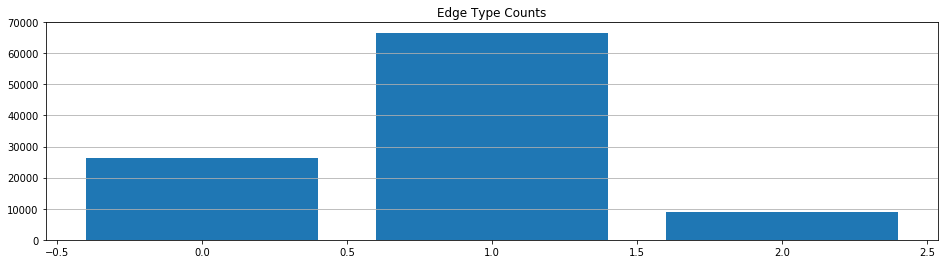

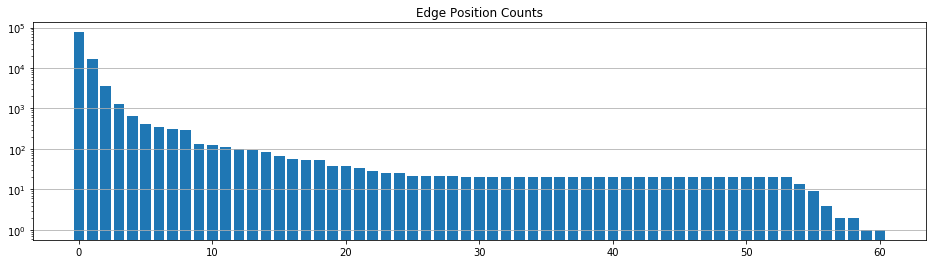

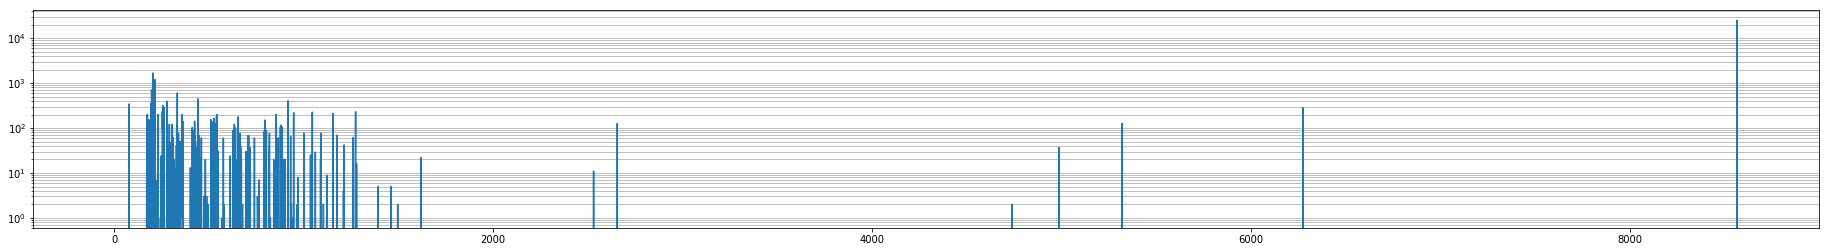

In [58]:
def collect_statement_texts(ds_base='/mnt/data/llvm/master_thesis_datasets/struct_inline_test/'):
    with open('/home/zacharias/ProGraML/deeplearning/ml4pl/poj104/vocabulary/dic_pickle', 'rb') as f:
        golden_dic = pickle.load(f)
    
    text_dic = {}

    ds_base = Path(ds_base)

    #files = list(ds_base.rglob('*.data.p'))
    files = list(ds_base.rglob('*.ll.pickle'))

    for j, file in enumerate(tqdm.tqdm(files)):
        if j > 1000: break
        if not file.is_file():
            continue
        try:
            with open(file, 'rb') as f:
                g = pickle.load(f)
            #nx_graph = load(file)
        except EOFError:
            print(f"Failing to unpickle bc. EOFError on {file}! Skipping ...")
            continue
        try:
            for i, node in g.nodes(data=True):
                text = node['preprocessed_text']
                if text in text_dic:
                    text_dic[text] = text_dic[text] + 1
                else:
                    text_dic[text] = 1
        except IndexError:
            print(f"Failing nx2data bc IndexError (prob. empty graph) on {file}! Skipping ...")
            continue
    text_list = [(v, k) for k,v in text_dic.items()]
    text_list = sorted(text_list, reverse=True)
    
    text_remaining = []
    for s, t in text_list:
        if t in golden_dic:
            text_remaining.append((True, s, t))
        else:
            text_remaining.append((False, s, t))
    return text_remaining

In [59]:
inlined_texts = collect_statement_texts()

100%|██████████| 20/20 [00:00<00:00, 30.25it/s]


In [67]:
sum([i[1] for i in inlined_texts[2:] if not i[0]])

4377

In [69]:
[i for i in inlined_texts]

[(False, 25115, '!IDENTIFIER'),
 (False, 2815, '!IMMEDIATE'),
 (True, 1684, 'br i1 <%ID>, label <%ID>, label <%ID>'),
 (False, 1508, ''),
 (True, 1199, 'br label <%ID>'),
 (True, 1084, '<%ID> = load opaque*, opaque** <@ID>, align 8'),
 (True, 703, 'store i32 <%ID>, i32* <@ID>, align 4'),
 (True, 606, '<%ID> = add nuw nsw i64 <%ID>, <INT>'),
 (True, 558, 'call void <@ID>(i64 <INT>, i8* nonnull <%ID>)'),
 (True, 548, '<%ID> = icmp eq i32 <%ID>, <INT>'),
 (True, 446, '<%ID> = load float, float* <%ID>, align 4'),
 (True, 404, '<%ID> = bitcast float* <%ID> to <4 x float>*'),
 (True, 395, '<%ID> = icmp eq i64 <%ID>, <INT>'),
 (True, 353, '<%ID> = trunc i64 <%ID> to i32'),
 (True, 344, '<%ID> = load i32, i32* <@ID>, align 4'),
 (True, 319, 'store float <%ID>, float* <%ID>, align 4'),
 (True, 289, 'ret void'),
 (True,
  283,
  '<%ID> = getelementptr inbounds [2048 x float], [2048 x float]* <%ID>, i64 <%ID>, i64 <%ID>'),
 (True, 232, '<%ID> = getelementptr inbounds float, float* <%ID>, i64 <%ID

  0%|          | 0/20 [00:00<?, ?it/s]

Processing...
Creating train dataset at /mnt/data/llvm/master_thesis_datasets/struct_inline_test
=== DATASET /mnt/data/llvm/master_thesis_datasets/struct_inline_test: Collecting .data.p files into dataset


100%|██████████| 20/20 [00:00<00:00, 21.39it/s]


 * COMPLETED * === DATASET /mnt/data/llvm/master_thesis_datasets/struct_inline_test: now pre-filtering...
 * COMPLETED * === DATASET /mnt/data/llvm/master_thesis_datasets/struct_inline_test: Completed filtering, now pre_transforming...
 * COMPLETED * === DATASET /mnt/data/llvm/master_thesis_datasets/struct_inline_test: saving to disk...
Done!
Data(edge_attr=[101968, 2], edge_index=[2, 101968], x=[53889, 2])

NewNCCDataset(20)
No of unique tokens 233/8568.
No of tokens in ds: 53,889.
No of !UNK in data: 4,377 -- [8.12%].
No of !ID in data: 25,115 -- [46.61%].


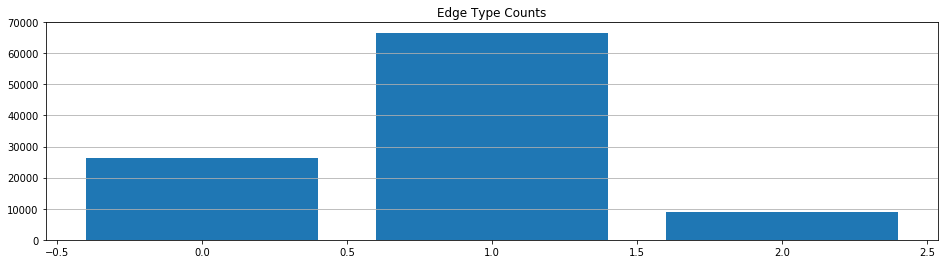

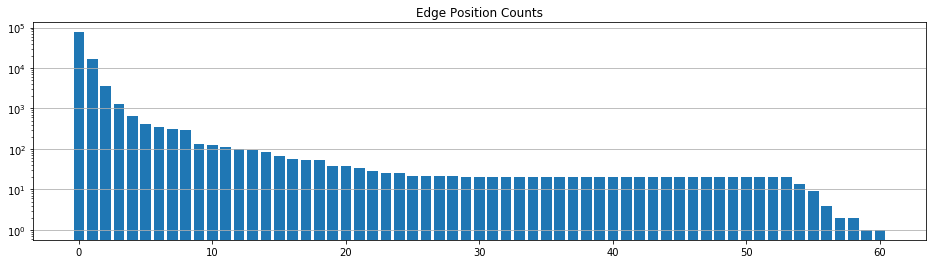

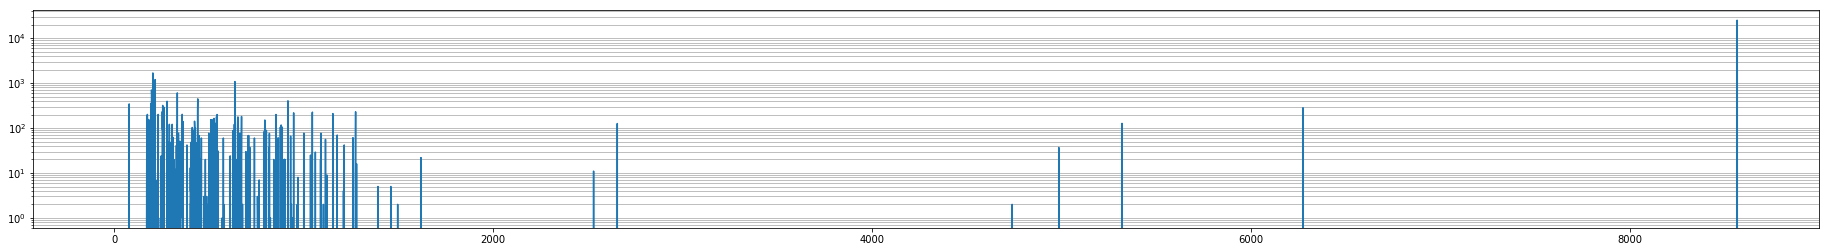

In [70]:
inlined_struct_data = NewNCCDataset('/mnt/data/llvm/master_thesis_datasets/struct_inline_test/')
print(inlined_struct_data.data)
print("")
print_dataset_stats(inlined_struct_data)

# retokenized ncc_data

In [6]:
ncc_data = NewNCCDataset('/home/zacharias/llvm_datasets/ncc_data/')
print(ncc_data.data)
print("")
#print_dataset_stats(ncc_data)

Data(edge_attr=[188493379, 2], edge_index=[2, 188493379], x=[98956919, 2])



In [7]:
# Data(edge_attr=[188493379, 2], edge_index=[2, 188493379], x=[98956919, 2])

NewNCCDataset(27428)
No of unique tokens 7276/8568.
No of tokens in ds: 98,956,919.
No of !UNK in data: 5,182,256 -- [5.24%].
No of !ID in data: 51,794,982 -- [52.34%].


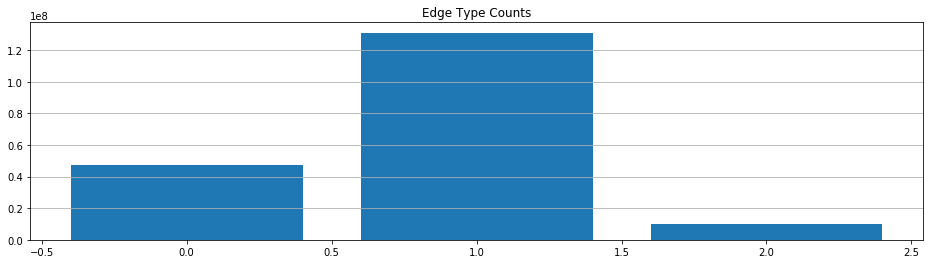

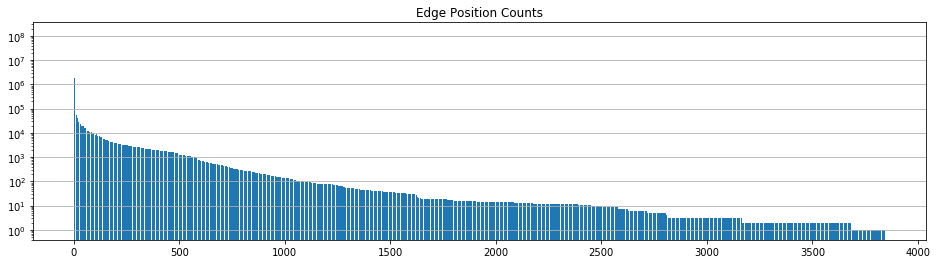

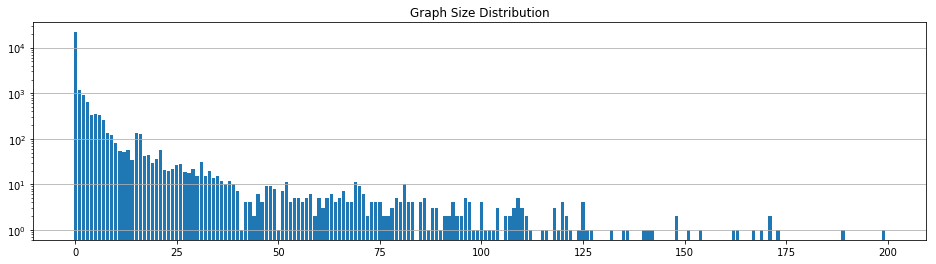

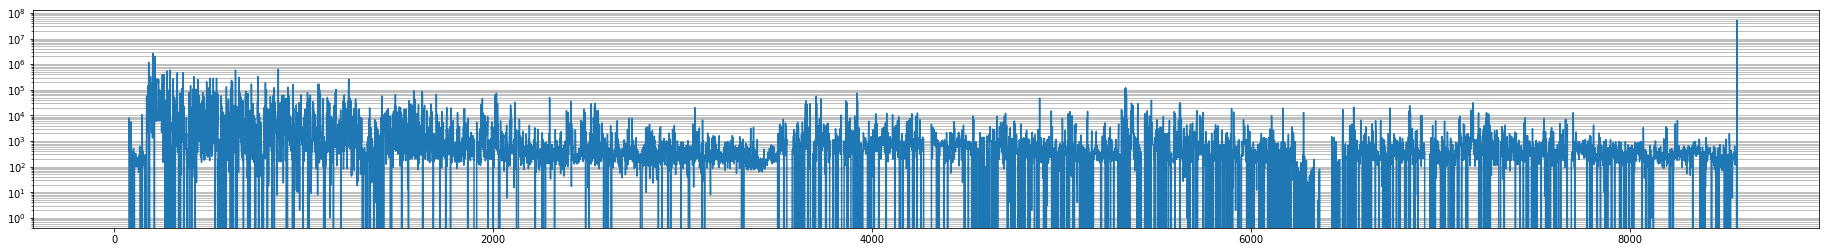

In [7]:
print_dataset_stats(ncc_data)